# Menarche Classification

Model selection, fitting model to training data, testing model on holdout data, validating and visualising results

### **Input:**

- **menarcheTrain_harm_red_matchedAgeScannerONLYSMRI.csv** - Harmonized and reduced training data matched by age and scanner
   
### **Output:**

- **classprobabilitesDFfinal_independently_harmonizedScanMatchedAgePredFeatures.csv** - Classprobabilities of menarche classification in holdout test dataset


In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
import seaborn as sns
import os

import sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score

In [2]:
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.5)

mypalettePink = ['#f78f8f','#a83246']
mypaletteBlue = sns.color_palette(['#C2F3F2','#1D9694'], as_cmap = True)

In [3]:
os.chdir('processedData\\')

In [4]:
plotdir = '..\\Plots\\'

In [5]:
sns.set_style({'axes.facecolor': 'white',
 'axes.edgecolor': '.15',
 'axes.grid': True,
 'axes.axisbelow': True,
 'axes.labelcolor': '.15',
 'figure.facecolor': 'white',
 'grid.color': '.8',
 'grid.linestyle': '-',
 'text.color': '.15',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'lines.solid_capstyle': 'projecting',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'xtick.bottom': False,
 'xtick.top': False,
 'ytick.left': False,
 'ytick.right': False,
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True})

In [6]:
sns.set_context({'font.size': 15.0,
 'axes.labelsize': 'medium',
 'axes.titlesize': 'large',
 'xtick.labelsize': 'medium',
 'ytick.labelsize': 'medium',
 'legend.fontsize': 'medium',
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0})

# 1. Model Training

In [7]:
## Load reduced dataset, i.e. redundant data such as means and totals are removed, 
## that has been harmonized for scan site and matched for Age and Scanner
Train = pd.read_csv('TrainAgePredFeaturesHarmonised.csv')
Train.sort_values(by = 'subjectkey', inplace=True)
## Dataframe containing demographic data
pds = pd.read_csv('menarcheTrain_harm_red_matchedAgeScannerONLYSMRI.csv')
pds.sort_values(by = 'subjectkey', inplace=True)
## extract menarche variable
pds = pds[['subjectkey','pds_f5_y_P']]
## add menarche variable to training feature dataframe
Train = Train.merge(pds, how = 'outer', on = 'subjectkey') 

In [8]:
## drop every column from X that isn't MRI data
X_TrainPred = Train.drop(columns=['subjectkey','pds_f5_y_P'])
## menarche data (1=pre, 4=post) as labels
y_Train = Train['pds_f5_y_P']

In [9]:
## Preprocess the dataset: Standardize by removing mean and scaling to unit variance
sc = StandardScaler()
X = sc.fit_transform(X_TrainPred)
## Encode target labels with value between 0 and n_classes-1
le = LabelEncoder()
Y = le.fit_transform(y_Train)

In [10]:
## Perform grid search to optimise the parameters for an LDA model
model = LinearDiscriminantAnalysis(n_components=1)

## perform nested stratified 10-fold crossvalidation
inner_cv = StratifiedKFold(n_splits=10)
outer_cv = StratifiedKFold(n_splits=10)

## do a search over all possible sovers and over the shrinkage options none, and fixed shrinkage parameters 
## within the possible range of 0 to 1 in increments of 0.1
grid_vals = {'solver': ['svd','lsqr','eigen'], 'shrinkage': [None,'auto',0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}

grid_lr_balanced = GridSearchCV(estimator=model, param_grid=grid_vals, scoring='balanced_accuracy', 
                       cv=inner_cv, refit=True, return_train_score=True,verbose=3) 

## crossvalidate the performance of the model
nested_score_balanced = cross_val_score(grid_lr_balanced, X=X, y=Y, cv=outer_cv)

## fit model to complete training features
grid_lr_balanced.fit(X, Y)
mymodel_balanced = grid_lr_balanced.best_estimator_

Fitting 10 folds for each of 39 candidates, totalling 390 fits
[CV 1/10] END shrinkage=None, solver=svd;, score=(train=0.733, test=0.557) total time=   0.0s
[CV 2/10] END shrinkage=None, solver=svd;, score=(train=0.724, test=0.593) total time=   0.0s
[CV 3/10] END shrinkage=None, solver=svd;, score=(train=0.731, test=0.593) total time=   0.0s
[CV 4/10] END shrinkage=None, solver=svd;, score=(train=0.722, test=0.579) total time=   0.0s
[CV 5/10] END shrinkage=None, solver=svd;, score=(train=0.727, test=0.550) total time=   0.0s
[CV 6/10] END shrinkage=None, solver=svd;, score=(train=0.729, test=0.590) total time=   0.0s
[CV 7/10] END shrinkage=None, solver=svd;, score=(train=0.736, test=0.446) total time=   0.0s
[CV 8/10] END shrinkage=None, solver=svd;, score=(train=0.728, test=0.561) total time=   0.0s
[CV 9/10] END shrinkage=None, solver=svd;, score=(train=0.715, test=0.626) total time=   0.0s
[CV 10/10] END shrinkage=None, solver=svd;, score=(train=0.725, test=0.561) total time=   0

[CV 4/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.694, test=0.600) total time=   0.0s
[CV 5/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.705, test=0.536) total time=   0.0s
[CV 6/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.701, test=0.641) total time=   0.0s
[CV 7/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.691, test=0.489) total time=   0.0s
[CV 8/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.704, test=0.597) total time=   0.0s
[CV 9/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.695, test=0.568) total time=   0.0s
[CV 10/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.709, test=0.568) total time=   0.0s
[CV 1/10] END shrinkage=0.1, solver=eigen;, score=(train=0.684, test=0.600) total time=   0.0s
[CV 2/10] END shrinkage=0.1, solver=eigen;, score=(train=0.692, test=0.614) total time=   0.0s
[CV 3/10] END shrinkage=0.1, solver=eigen;, score=(train=0.700, test=0.586) total time=   0.0s
[CV 4/10] END shrinkage=0.1, solver=eigen;, score=(train

[CV 9/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.678, test=0.525) total time=   0.0s
[CV 10/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.689, test=0.575) total time=   0.0s
[CV 1/10] END shrinkage=0.4, solver=eigen;, score=(train=0.657, test=0.629) total time=   0.0s
[CV 2/10] END shrinkage=0.4, solver=eigen;, score=(train=0.678, test=0.600) total time=   0.0s
[CV 3/10] END shrinkage=0.4, solver=eigen;, score=(train=0.676, test=0.607) total time=   0.0s
[CV 4/10] END shrinkage=0.4, solver=eigen;, score=(train=0.665, test=0.586) total time=   0.0s
[CV 5/10] END shrinkage=0.4, solver=eigen;, score=(train=0.680, test=0.529) total time=   0.0s
[CV 6/10] END shrinkage=0.4, solver=eigen;, score=(train=0.654, test=0.641) total time=   0.0s
[CV 7/10] END shrinkage=0.4, solver=eigen;, score=(train=0.666, test=0.511) total time=   0.0s
[CV 8/10] END shrinkage=0.4, solver=eigen;, score=(train=0.674, test=0.590) total time=   0.0s
[CV 9/10] END shrinkage=0.4, solver=eigen;, score=(

[CV 9/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.656, test=0.539) total time=   0.0s
[CV 10/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.650, test=0.625) total time=   0.0s
[CV 1/10] END shrinkage=0.7, solver=eigen;, score=(train=0.650, test=0.621) total time=   0.0s
[CV 2/10] END shrinkage=0.7, solver=eigen;, score=(train=0.641, test=0.586) total time=   0.0s
[CV 3/10] END shrinkage=0.7, solver=eigen;, score=(train=0.639, test=0.614) total time=   0.0s
[CV 4/10] END shrinkage=0.7, solver=eigen;, score=(train=0.648, test=0.571) total time=   0.0s
[CV 5/10] END shrinkage=0.7, solver=eigen;, score=(train=0.660, test=0.564) total time=   0.0s
[CV 6/10] END shrinkage=0.7, solver=eigen;, score=(train=0.636, test=0.684) total time=   0.0s
[CV 7/10] END shrinkage=0.7, solver=eigen;, score=(train=0.646, test=0.597) total time=   0.0s
[CV 8/10] END shrinkage=0.7, solver=eigen;, score=(train=0.651, test=0.590) total time=   0.0s
[CV 9/10] END shrinkage=0.7, solver=eigen;, score=(

[CV 3/10] END shrinkage=1, solver=eigen;, score=(train=0.578, test=0.600) total time=   0.0s
[CV 4/10] END shrinkage=1, solver=eigen;, score=(train=0.583, test=0.536) total time=   0.0s
[CV 5/10] END shrinkage=1, solver=eigen;, score=(train=0.586, test=0.579) total time=   0.0s
[CV 6/10] END shrinkage=1, solver=eigen;, score=(train=0.584, test=0.597) total time=   0.0s
[CV 7/10] END shrinkage=1, solver=eigen;, score=(train=0.585, test=0.546) total time=   0.0s
[CV 8/10] END shrinkage=1, solver=eigen;, score=(train=0.583, test=0.576) total time=   0.0s
[CV 9/10] END shrinkage=1, solver=eigen;, score=(train=0.593, test=0.518) total time=   0.0s
[CV 10/10] END shrinkage=1, solver=eigen;, score=(train=0.580, test=0.597) total time=   0.0s
Fitting 10 folds for each of 39 candidates, totalling 390 fits
[CV 1/10] END shrinkage=None, solver=svd;, score=(train=0.731, test=0.614) total time=   0.0s
[CV 2/10] END shrinkage=None, solver=svd;, score=(train=0.709, test=0.536) total time=   0.0s
[CV 

C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
120 fits failed out of a total of 390.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\discriminant_

[CV 4/10] END shrinkage=None, solver=svd;, score=(train=0.724, test=0.593) total time=   0.0s
[CV 5/10] END shrinkage=None, solver=svd;, score=(train=0.716, test=0.514) total time=   0.0s
[CV 6/10] END shrinkage=None, solver=svd;, score=(train=0.725, test=0.539) total time=   0.0s
[CV 7/10] END shrinkage=None, solver=svd;, score=(train=0.736, test=0.482) total time=   0.0s
[CV 8/10] END shrinkage=None, solver=svd;, score=(train=0.717, test=0.554) total time=   0.0s
[CV 9/10] END shrinkage=None, solver=svd;, score=(train=0.733, test=0.575) total time=   0.0s
[CV 10/10] END shrinkage=None, solver=svd;, score=(train=0.717, test=0.547) total time=   0.0s
[CV 1/10] END shrinkage=None, solver=lsqr;, score=(train=0.731, test=0.614) total time=   0.0s
[CV 2/10] END shrinkage=None, solver=lsqr;, score=(train=0.709, test=0.536) total time=   0.0s
[CV 3/10] END shrinkage=None, solver=lsqr;, score=(train=0.727, test=0.579) total time=   0.0s
[CV 4/10] END shrinkage=None, solver=lsqr;, score=(train

[CV 6/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.699, test=0.596) total time=   0.0s
[CV 7/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.708, test=0.482) total time=   0.0s
[CV 8/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.704, test=0.590) total time=   0.0s
[CV 9/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.694, test=0.525) total time=   0.0s
[CV 10/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.701, test=0.562) total time=   0.0s
[CV 1/10] END shrinkage=0.1, solver=eigen;, score=(train=0.684, test=0.671) total time=   0.0s
[CV 2/10] END shrinkage=0.1, solver=eigen;, score=(train=0.697, test=0.607) total time=   0.0s
[CV 3/10] END shrinkage=0.1, solver=eigen;, score=(train=0.692, test=0.607) total time=   0.0s
[CV 4/10] END shrinkage=0.1, solver=eigen;, score=(train=0.698, test=0.571) total time=   0.0s
[CV 5/10] END shrinkage=0.1, solver=eigen;, score=(train=0.700, test=0.543) total time=   0.0s
[CV 6/10] END shrinkage=0.1, solver=eigen;, score=(tra

[CV 8/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.683, test=0.575) total time=   0.0s
[CV 9/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.677, test=0.540) total time=   0.0s
[CV 10/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.671, test=0.605) total time=   0.0s
[CV 1/10] END shrinkage=0.4, solver=eigen;, score=(train=0.655, test=0.664) total time=   0.0s
[CV 2/10] END shrinkage=0.4, solver=eigen;, score=(train=0.678, test=0.629) total time=   0.0s
[CV 3/10] END shrinkage=0.4, solver=eigen;, score=(train=0.679, test=0.636) total time=   0.0s
[CV 4/10] END shrinkage=0.4, solver=eigen;, score=(train=0.671, test=0.586) total time=   0.0s
[CV 5/10] END shrinkage=0.4, solver=eigen;, score=(train=0.673, test=0.529) total time=   0.0s
[CV 6/10] END shrinkage=0.4, solver=eigen;, score=(train=0.657, test=0.669) total time=   0.0s
[CV 7/10] END shrinkage=0.4, solver=eigen;, score=(train=0.678, test=0.489) total time=   0.0s
[CV 8/10] END shrinkage=0.4, solver=eigen;, score=(t

[CV 9/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.660, test=0.554) total time=   0.0s
[CV 10/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.650, test=0.626) total time=   0.0s
[CV 1/10] END shrinkage=0.7, solver=eigen;, score=(train=0.652, test=0.607) total time=   0.0s
[CV 2/10] END shrinkage=0.7, solver=eigen;, score=(train=0.652, test=0.629) total time=   0.0s
[CV 3/10] END shrinkage=0.7, solver=eigen;, score=(train=0.648, test=0.607) total time=   0.0s
[CV 4/10] END shrinkage=0.7, solver=eigen;, score=(train=0.656, test=0.614) total time=   0.0s
[CV 5/10] END shrinkage=0.7, solver=eigen;, score=(train=0.663, test=0.557) total time=   0.0s
[CV 6/10] END shrinkage=0.7, solver=eigen;, score=(train=0.639, test=0.661) total time=   0.0s
[CV 7/10] END shrinkage=0.7, solver=eigen;, score=(train=0.650, test=0.576) total time=   0.0s
[CV 8/10] END shrinkage=0.7, solver=eigen;, score=(train=0.659, test=0.576) total time=   0.0s
[CV 9/10] END shrinkage=0.7, solver=eigen;, score=(

[CV 1/10] END shrinkage=1, solver=eigen;, score=(train=0.582, test=0.557) total time=   0.0s
[CV 2/10] END shrinkage=1, solver=eigen;, score=(train=0.580, test=0.643) total time=   0.0s
[CV 3/10] END shrinkage=1, solver=eigen;, score=(train=0.577, test=0.600) total time=   0.0s
[CV 4/10] END shrinkage=1, solver=eigen;, score=(train=0.580, test=0.543) total time=   0.0s
[CV 5/10] END shrinkage=1, solver=eigen;, score=(train=0.583, test=0.586) total time=   0.0s
[CV 6/10] END shrinkage=1, solver=eigen;, score=(train=0.583, test=0.597) total time=   0.0s
[CV 7/10] END shrinkage=1, solver=eigen;, score=(train=0.580, test=0.547) total time=   0.0s
[CV 8/10] END shrinkage=1, solver=eigen;, score=(train=0.586, test=0.583) total time=   0.0s
[CV 9/10] END shrinkage=1, solver=eigen;, score=(train=0.593, test=0.533) total time=   0.0s
[CV 10/10] END shrinkage=1, solver=eigen;, score=(train=0.580, test=0.605) total time=   0.0s
Fitting 10 folds for each of 39 candidates, totalling 390 fits
[CV 1/

C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
120 fits failed out of a total of 390.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\discriminant_

[CV 2/10] END shrinkage=None, solver=svd;, score=(train=0.719, test=0.671) total time=   0.0s
[CV 3/10] END shrinkage=None, solver=svd;, score=(train=0.727, test=0.614) total time=   0.0s
[CV 4/10] END shrinkage=None, solver=svd;, score=(train=0.726, test=0.550) total time=   0.0s
[CV 5/10] END shrinkage=None, solver=svd;, score=(train=0.724, test=0.579) total time=   0.0s
[CV 6/10] END shrinkage=None, solver=svd;, score=(train=0.732, test=0.604) total time=   0.0s
[CV 7/10] END shrinkage=None, solver=svd;, score=(train=0.735, test=0.504) total time=   0.0s
[CV 8/10] END shrinkage=None, solver=svd;, score=(train=0.724, test=0.561) total time=   0.0s
[CV 9/10] END shrinkage=None, solver=svd;, score=(train=0.734, test=0.554) total time=   0.0s
[CV 10/10] END shrinkage=None, solver=svd;, score=(train=0.731, test=0.547) total time=   0.0s
[CV 1/10] END shrinkage=None, solver=lsqr;, score=(train=0.727, test=0.614) total time=   0.0s
[CV 2/10] END shrinkage=None, solver=lsqr;, score=(train=0

[CV 2/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.703, test=0.657) total time=   0.0s
[CV 3/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.701, test=0.650) total time=   0.0s
[CV 4/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.712, test=0.579) total time=   0.0s
[CV 5/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.719, test=0.571) total time=   0.0s
[CV 6/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.711, test=0.618) total time=   0.0s
[CV 7/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.723, test=0.490) total time=   0.0s
[CV 8/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.716, test=0.597) total time=   0.0s
[CV 9/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.723, test=0.533) total time=   0.0s
[CV 10/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.713, test=0.540) total time=   0.0s
[CV 1/10] END shrinkage=0.1, solver=eigen;, score=(train=0.705, test=0.686) total time=   0.0s
[CV 2/10] END shrinkage=0.1, solver=eigen;, score=(train=0

[CV 1/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.679, test=0.686) total time=   0.0s
[CV 2/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.686, test=0.657) total time=   0.0s
[CV 3/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.688, test=0.657) total time=   0.0s
[CV 4/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.688, test=0.571) total time=   0.0s
[CV 5/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.692, test=0.557) total time=   0.0s
[CV 6/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.683, test=0.633) total time=   0.0s
[CV 7/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.701, test=0.504) total time=   0.0s
[CV 8/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.701, test=0.597) total time=   0.0s
[CV 9/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.699, test=0.548) total time=   0.0s
[CV 10/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.689, test=0.590) total time=   0.0s
[CV 1/10] END shrinkage=0.4, solver=eigen;, score=(train=0.

[CV 1/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.640, test=0.664) total time=   0.0s
[CV 2/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.653, test=0.650) total time=   0.0s
[CV 3/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.644, test=0.636) total time=   0.0s
[CV 4/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.653, test=0.543) total time=   0.0s
[CV 5/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.653, test=0.571) total time=   0.0s
[CV 6/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.647, test=0.647) total time=   0.0s
[CV 7/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.650, test=0.548) total time=   0.0s
[CV 8/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.662, test=0.582) total time=   0.0s
[CV 9/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.656, test=0.540) total time=   0.0s
[CV 10/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.658, test=0.619) total time=   0.0s
[CV 1/10] END shrinkage=0.7, solver=eigen;, score=(train=0.

[CV 3/10] END shrinkage=1, solver=lsqr;, score=(train=0.571, test=0.614) total time=   0.0s
[CV 4/10] END shrinkage=1, solver=lsqr;, score=(train=0.577, test=0.550) total time=   0.0s
[CV 5/10] END shrinkage=1, solver=lsqr;, score=(train=0.579, test=0.579) total time=   0.0s
[CV 6/10] END shrinkage=1, solver=lsqr;, score=(train=0.580, test=0.597) total time=   0.0s
[CV 7/10] END shrinkage=1, solver=lsqr;, score=(train=0.580, test=0.547) total time=   0.0s
[CV 8/10] END shrinkage=1, solver=lsqr;, score=(train=0.580, test=0.568) total time=   0.0s
[CV 9/10] END shrinkage=1, solver=lsqr;, score=(train=0.587, test=0.547) total time=   0.0s
[CV 10/10] END shrinkage=1, solver=lsqr;, score=(train=0.579, test=0.605) total time=   0.0s
[CV 1/10] END shrinkage=1, solver=eigen;, score=(train=0.582, test=0.557) total time=   0.0s
[CV 2/10] END shrinkage=1, solver=eigen;, score=(train=0.578, test=0.579) total time=   0.0s
[CV 3/10] END shrinkage=1, solver=eigen;, score=(train=0.571, test=0.614) tot

C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
120 fits failed out of a total of 390.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\discriminant_

[CV 4/10] END shrinkage=None, solver=svd;, score=(train=0.716, test=0.521) total time=   0.0s
[CV 5/10] END shrinkage=None, solver=svd;, score=(train=0.716, test=0.507) total time=   0.0s
[CV 6/10] END shrinkage=None, solver=svd;, score=(train=0.727, test=0.561) total time=   0.0s
[CV 7/10] END shrinkage=None, solver=svd;, score=(train=0.732, test=0.518) total time=   0.0s
[CV 8/10] END shrinkage=None, solver=svd;, score=(train=0.719, test=0.590) total time=   0.0s
[CV 9/10] END shrinkage=None, solver=svd;, score=(train=0.724, test=0.569) total time=   0.0s
[CV 10/10] END shrinkage=None, solver=svd;, score=(train=0.734, test=0.554) total time=   0.0s
[CV 1/10] END shrinkage=None, solver=lsqr;, score=(train=0.730, test=0.600) total time=   0.0s
[CV 2/10] END shrinkage=None, solver=lsqr;, score=(train=0.712, test=0.636) total time=   0.0s
[CV 3/10] END shrinkage=None, solver=lsqr;, score=(train=0.724, test=0.557) total time=   0.0s
[CV 4/10] END shrinkage=None, solver=lsqr;, score=(train

[CV 1/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.702, test=0.700) total time=   0.0s
[CV 2/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.700, test=0.636) total time=   0.0s
[CV 3/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.709, test=0.614) total time=   0.0s
[CV 4/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.698, test=0.550) total time=   0.0s
[CV 5/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.698, test=0.536) total time=   0.0s
[CV 6/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.711, test=0.596) total time=   0.0s
[CV 7/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.710, test=0.482) total time=   0.0s
[CV 8/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.701, test=0.561) total time=   0.0s
[CV 9/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.708, test=0.554) total time=   0.0s
[CV 10/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.707, test=0.576) total time=   0.0s
[CV 1/10] END shrinkage=0.1, solver=eigen;, score=(train=0.

[CV 3/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.685, test=0.621) total time=   0.0s
[CV 4/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.676, test=0.600) total time=   0.0s
[CV 5/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.687, test=0.536) total time=   0.0s
[CV 6/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.681, test=0.604) total time=   0.0s
[CV 7/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.695, test=0.511) total time=   0.0s
[CV 8/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.689, test=0.561) total time=   0.0s
[CV 9/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.683, test=0.540) total time=   0.0s
[CV 10/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.690, test=0.605) total time=   0.0s
[CV 1/10] END shrinkage=0.4, solver=eigen;, score=(train=0.678, test=0.679) total time=   0.0s
[CV 2/10] END shrinkage=0.4, solver=eigen;, score=(train=0.676, test=0.679) total time=   0.0s
[CV 3/10] END shrinkage=0.4, solver=eigen;, score=(train=

[CV 3/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.645, test=0.657) total time=   0.0s
[CV 4/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.645, test=0.636) total time=   0.0s
[CV 5/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.659, test=0.529) total time=   0.0s
[CV 6/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.647, test=0.640) total time=   0.0s
[CV 7/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.661, test=0.533) total time=   0.0s
[CV 8/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.663, test=0.561) total time=   0.0s
[CV 9/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.662, test=0.554) total time=   0.0s
[CV 10/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.647, test=0.633) total time=   0.0s
[CV 1/10] END shrinkage=0.7, solver=eigen;, score=(train=0.647, test=0.643) total time=   0.0s
[CV 2/10] END shrinkage=0.7, solver=eigen;, score=(train=0.651, test=0.650) total time=   0.0s
[CV 3/10] END shrinkage=0.7, solver=eigen;, score=(train=

[CV 4/10] END shrinkage=1, solver=lsqr;, score=(train=0.577, test=0.593) total time=   0.0s
[CV 5/10] END shrinkage=1, solver=lsqr;, score=(train=0.586, test=0.579) total time=   0.0s
[CV 6/10] END shrinkage=1, solver=lsqr;, score=(train=0.581, test=0.590) total time=   0.0s
[CV 7/10] END shrinkage=1, solver=lsqr;, score=(train=0.586, test=0.547) total time=   0.0s
[CV 8/10] END shrinkage=1, solver=lsqr;, score=(train=0.588, test=0.569) total time=   0.0s
[CV 9/10] END shrinkage=1, solver=lsqr;, score=(train=0.592, test=0.540) total time=   0.0s
[CV 10/10] END shrinkage=1, solver=lsqr;, score=(train=0.583, test=0.605) total time=   0.0s
[CV 1/10] END shrinkage=1, solver=eigen;, score=(train=0.581, test=0.557) total time=   0.0s
[CV 2/10] END shrinkage=1, solver=eigen;, score=(train=0.580, test=0.586) total time=   0.0s
[CV 3/10] END shrinkage=1, solver=eigen;, score=(train=0.580, test=0.621) total time=   0.0s
[CV 4/10] END shrinkage=1, solver=eigen;, score=(train=0.577, test=0.593) to

C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
120 fits failed out of a total of 390.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\discriminant_

[CV 4/10] END shrinkage=None, solver=svd;, score=(train=0.727, test=0.536) total time=   0.0s
[CV 5/10] END shrinkage=None, solver=svd;, score=(train=0.719, test=0.607) total time=   0.0s
[CV 6/10] END shrinkage=None, solver=svd;, score=(train=0.733, test=0.590) total time=   0.0s
[CV 7/10] END shrinkage=None, solver=svd;, score=(train=0.735, test=0.518) total time=   0.0s
[CV 8/10] END shrinkage=None, solver=svd;, score=(train=0.721, test=0.568) total time=   0.0s
[CV 9/10] END shrinkage=None, solver=svd;, score=(train=0.731, test=0.547) total time=   0.0s
[CV 10/10] END shrinkage=None, solver=svd;, score=(train=0.720, test=0.561) total time=   0.0s
[CV 1/10] END shrinkage=None, solver=lsqr;, score=(train=0.727, test=0.586) total time=   0.0s
[CV 2/10] END shrinkage=None, solver=lsqr;, score=(train=0.720, test=0.629) total time=   0.0s
[CV 3/10] END shrinkage=None, solver=lsqr;, score=(train=0.724, test=0.579) total time=   0.0s
[CV 4/10] END shrinkage=None, solver=lsqr;, score=(train

[CV 3/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.709, test=0.557) total time=   0.0s
[CV 4/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.703, test=0.550) total time=   0.0s
[CV 5/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.696, test=0.571) total time=   0.0s
[CV 6/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.705, test=0.633) total time=   0.0s
[CV 7/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.714, test=0.511) total time=   0.0s
[CV 8/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.712, test=0.597) total time=   0.0s
[CV 9/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.713, test=0.569) total time=   0.0s
[CV 10/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.712, test=0.590) total time=   0.0s
[CV 1/10] END shrinkage=0.1, solver=eigen;, score=(train=0.704, test=0.686) total time=   0.0s
[CV 2/10] END shrinkage=0.1, solver=eigen;, score=(train=0.692, test=0.643) total time=   0.0s
[CV 3/10] END shrinkage=0.1, solver=eigen;, score=(train=

[CV 7/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.689, test=0.525) total time=   0.0s
[CV 8/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.686, test=0.611) total time=   0.0s
[CV 9/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.690, test=0.533) total time=   0.0s
[CV 10/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.687, test=0.583) total time=   0.0s
[CV 1/10] END shrinkage=0.4, solver=eigen;, score=(train=0.672, test=0.693) total time=   0.0s
[CV 2/10] END shrinkage=0.4, solver=eigen;, score=(train=0.680, test=0.664) total time=   0.0s
[CV 3/10] END shrinkage=0.4, solver=eigen;, score=(train=0.696, test=0.614) total time=   0.0s
[CV 4/10] END shrinkage=0.4, solver=eigen;, score=(train=0.683, test=0.593) total time=   0.0s
[CV 5/10] END shrinkage=0.4, solver=eigen;, score=(train=0.681, test=0.543) total time=   0.0s
[CV 6/10] END shrinkage=0.4, solver=eigen;, score=(train=0.670, test=0.683) total time=   0.0s
[CV 7/10] END shrinkage=0.4, solver=eigen;, score=(tr

[CV 6/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.645, test=0.676) total time=   0.0s
[CV 7/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.650, test=0.554) total time=   0.0s
[CV 8/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.658, test=0.554) total time=   0.0s
[CV 9/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.660, test=0.555) total time=   0.0s
[CV 10/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.651, test=0.605) total time=   0.0s
[CV 1/10] END shrinkage=0.7, solver=eigen;, score=(train=0.657, test=0.643) total time=   0.0s
[CV 2/10] END shrinkage=0.7, solver=eigen;, score=(train=0.646, test=0.657) total time=   0.0s
[CV 3/10] END shrinkage=0.7, solver=eigen;, score=(train=0.653, test=0.621) total time=   0.0s
[CV 4/10] END shrinkage=0.7, solver=eigen;, score=(train=0.639, test=0.614) total time=   0.0s
[CV 5/10] END shrinkage=0.7, solver=eigen;, score=(train=0.652, test=0.557) total time=   0.0s
[CV 6/10] END shrinkage=0.7, solver=eigen;, score=(tra

[CV 9/10] END shrinkage=1, solver=lsqr;, score=(train=0.596, test=0.533) total time=   0.0s
[CV 10/10] END shrinkage=1, solver=lsqr;, score=(train=0.583, test=0.605) total time=   0.0s
[CV 1/10] END shrinkage=1, solver=eigen;, score=(train=0.578, test=0.557) total time=   0.0s
[CV 2/10] END shrinkage=1, solver=eigen;, score=(train=0.579, test=0.586) total time=   0.0s
[CV 3/10] END shrinkage=1, solver=eigen;, score=(train=0.581, test=0.614) total time=   0.0s
[CV 4/10] END shrinkage=1, solver=eigen;, score=(train=0.576, test=0.600) total time=   0.0s
[CV 5/10] END shrinkage=1, solver=eigen;, score=(train=0.584, test=0.579) total time=   0.0s
[CV 6/10] END shrinkage=1, solver=eigen;, score=(train=0.590, test=0.590) total time=   0.0s
[CV 7/10] END shrinkage=1, solver=eigen;, score=(train=0.580, test=0.547) total time=   0.0s
[CV 8/10] END shrinkage=1, solver=eigen;, score=(train=0.591, test=0.569) total time=   0.0s
[CV 9/10] END shrinkage=1, solver=eigen;, score=(train=0.596, test=0.53

C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
120 fits failed out of a total of 390.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\discriminant_

Fitting 10 folds for each of 39 candidates, totalling 390 fits
[CV 1/10] END shrinkage=None, solver=svd;, score=(train=0.729, test=0.621) total time=   0.0s
[CV 2/10] END shrinkage=None, solver=svd;, score=(train=0.716, test=0.636) total time=   0.0s
[CV 3/10] END shrinkage=None, solver=svd;, score=(train=0.726, test=0.564) total time=   0.0s
[CV 4/10] END shrinkage=None, solver=svd;, score=(train=0.720, test=0.579) total time=   0.0s
[CV 5/10] END shrinkage=None, solver=svd;, score=(train=0.723, test=0.657) total time=   0.0s
[CV 6/10] END shrinkage=None, solver=svd;, score=(train=0.722, test=0.583) total time=   0.0s
[CV 7/10] END shrinkage=None, solver=svd;, score=(train=0.733, test=0.453) total time=   0.0s
[CV 8/10] END shrinkage=None, solver=svd;, score=(train=0.717, test=0.597) total time=   0.0s
[CV 9/10] END shrinkage=None, solver=svd;, score=(train=0.736, test=0.504) total time=   0.0s
[CV 10/10] END shrinkage=None, solver=svd;, score=(train=0.719, test=0.533) total time=   0

[CV 9/10] END shrinkage=0, solver=eigen;, score=(train=0.736, test=0.504) total time=   0.0s
[CV 10/10] END shrinkage=0, solver=eigen;, score=(train=0.719, test=0.533) total time=   0.0s
[CV 1/10] END shrinkage=0.1, solver=svd;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/10] END shrinkage=0.1, solver=svd;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/10] END shrinkage=0.1, solver=svd;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/10] END shrinkage=0.1, solver=svd;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/10] END shrinkage=0.1, solver=svd;, score=(train=nan, test=nan) total time=   0.0s
[CV 6/10] END shrinkage=0.1, solver=svd;, score=(train=nan, test=nan) total time=   0.0s
[CV 7/10] END shrinkage=0.1, solver=svd;, score=(train=nan, test=nan) total time=   0.0s
[CV 8/10] END shrinkage=0.1, solver=svd;, score=(train=nan, test=nan) total time=   0.0s
[CV 9/10] END shrinkage=0.1, solver=svd;, score=(train=nan, test=nan) total time=   0.0s
[CV 10/10] E

[CV 2/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.666, test=0.664) total time=   0.0s
[CV 3/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.679, test=0.571) total time=   0.0s
[CV 4/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.680, test=0.607) total time=   0.0s
[CV 5/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.670, test=0.629) total time=   0.0s
[CV 6/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.679, test=0.590) total time=   0.0s
[CV 7/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.683, test=0.504) total time=   0.0s
[CV 8/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.675, test=0.605) total time=   0.0s
[CV 9/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.682, test=0.547) total time=   0.0s
[CV 10/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.677, test=0.540) total time=   0.0s
[CV 1/10] END shrinkage=0.4, solver=eigen;, score=(train=0.673, test=0.693) total time=   0.0s
[CV 2/10] END shrinkage=0.4, solver=eigen;, score=(train=0

[CV 1/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.638, test=0.650) total time=   0.0s
[CV 2/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.651, test=0.636) total time=   0.0s
[CV 3/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.650, test=0.593) total time=   0.0s
[CV 4/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.649, test=0.607) total time=   0.0s
[CV 5/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.645, test=0.586) total time=   0.0s
[CV 6/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.654, test=0.612) total time=   0.0s
[CV 7/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.657, test=0.519) total time=   0.0s
[CV 8/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.654, test=0.576) total time=   0.0s
[CV 9/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.665, test=0.583) total time=   0.0s
[CV 10/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.656, test=0.612) total time=   0.0s
[CV 1/10] END shrinkage=0.7, solver=eigen;, score=(train=0.

[CV 2/10] END shrinkage=1, solver=lsqr;, score=(train=0.581, test=0.586) total time=   0.0s
[CV 3/10] END shrinkage=1, solver=lsqr;, score=(train=0.578, test=0.621) total time=   0.0s
[CV 4/10] END shrinkage=1, solver=lsqr;, score=(train=0.575, test=0.593) total time=   0.0s
[CV 5/10] END shrinkage=1, solver=lsqr;, score=(train=0.583, test=0.564) total time=   0.0s
[CV 6/10] END shrinkage=1, solver=lsqr;, score=(train=0.580, test=0.554) total time=   0.0s
[CV 7/10] END shrinkage=1, solver=lsqr;, score=(train=0.580, test=0.561) total time=   0.0s
[CV 8/10] END shrinkage=1, solver=lsqr;, score=(train=0.575, test=0.576) total time=   0.0s
[CV 9/10] END shrinkage=1, solver=lsqr;, score=(train=0.580, test=0.540) total time=   0.0s
[CV 10/10] END shrinkage=1, solver=lsqr;, score=(train=0.580, test=0.590) total time=   0.0s
[CV 1/10] END shrinkage=1, solver=eigen;, score=(train=0.579, test=0.571) total time=   0.0s
[CV 2/10] END shrinkage=1, solver=eigen;, score=(train=0.581, test=0.586) tota

C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
120 fits failed out of a total of 390.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\discriminant_

[CV 4/10] END shrinkage=None, solver=svd;, score=(train=0.735, test=0.593) total time=   0.0s
[CV 5/10] END shrinkage=None, solver=svd;, score=(train=0.726, test=0.600) total time=   0.0s
[CV 6/10] END shrinkage=None, solver=svd;, score=(train=0.735, test=0.547) total time=   0.0s
[CV 7/10] END shrinkage=None, solver=svd;, score=(train=0.736, test=0.532) total time=   0.0s
[CV 8/10] END shrinkage=None, solver=svd;, score=(train=0.719, test=0.612) total time=   0.0s
[CV 9/10] END shrinkage=None, solver=svd;, score=(train=0.724, test=0.626) total time=   0.0s
[CV 10/10] END shrinkage=None, solver=svd;, score=(train=0.733, test=0.533) total time=   0.0s
[CV 1/10] END shrinkage=None, solver=lsqr;, score=(train=0.725, test=0.614) total time=   0.0s
[CV 2/10] END shrinkage=None, solver=lsqr;, score=(train=0.722, test=0.643) total time=   0.0s
[CV 3/10] END shrinkage=None, solver=lsqr;, score=(train=0.725, test=0.586) total time=   0.0s
[CV 4/10] END shrinkage=None, solver=lsqr;, score=(train

[CV 2/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.704, test=0.664) total time=   0.0s
[CV 3/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.711, test=0.607) total time=   0.0s
[CV 4/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.703, test=0.593) total time=   0.0s
[CV 5/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.708, test=0.571) total time=   0.0s
[CV 6/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.709, test=0.504) total time=   0.0s
[CV 7/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.720, test=0.546) total time=   0.0s
[CV 8/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.701, test=0.604) total time=   0.0s
[CV 9/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.705, test=0.569) total time=   0.0s
[CV 10/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.713, test=0.526) total time=   0.0s
[CV 1/10] END shrinkage=0.1, solver=eigen;, score=(train=0.696, test=0.686) total time=   0.0s
[CV 2/10] END shrinkage=0.1, solver=eigen;, score=(train=0

[CV 5/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.678, test=0.571) total time=   0.0s
[CV 6/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.680, test=0.504) total time=   0.0s
[CV 7/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.685, test=0.540) total time=   0.0s
[CV 8/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.689, test=0.590) total time=   0.0s
[CV 9/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.690, test=0.511) total time=   0.0s
[CV 10/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.678, test=0.554) total time=   0.0s
[CV 1/10] END shrinkage=0.4, solver=eigen;, score=(train=0.669, test=0.679) total time=   0.0s
[CV 2/10] END shrinkage=0.4, solver=eigen;, score=(train=0.672, test=0.636) total time=   0.0s
[CV 3/10] END shrinkage=0.4, solver=eigen;, score=(train=0.687, test=0.621) total time=   0.0s
[CV 4/10] END shrinkage=0.4, solver=eigen;, score=(train=0.681, test=0.629) total time=   0.0s
[CV 5/10] END shrinkage=0.4, solver=eigen;, score=(trai

[CV 7/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.654, test=0.605) total time=   0.0s
[CV 8/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.660, test=0.561) total time=   0.0s
[CV 9/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.670, test=0.533) total time=   0.0s
[CV 10/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.661, test=0.619) total time=   0.0s
[CV 1/10] END shrinkage=0.7, solver=eigen;, score=(train=0.644, test=0.643) total time=   0.0s
[CV 2/10] END shrinkage=0.7, solver=eigen;, score=(train=0.653, test=0.650) total time=   0.0s
[CV 3/10] END shrinkage=0.7, solver=eigen;, score=(train=0.648, test=0.636) total time=   0.0s
[CV 4/10] END shrinkage=0.7, solver=eigen;, score=(train=0.647, test=0.643) total time=   0.0s
[CV 5/10] END shrinkage=0.7, solver=eigen;, score=(train=0.649, test=0.600) total time=   0.0s
[CV 6/10] END shrinkage=0.7, solver=eigen;, score=(train=0.659, test=0.533) total time=   0.0s
[CV 7/10] END shrinkage=0.7, solver=eigen;, score=(tr

[CV 9/10] END shrinkage=1, solver=lsqr;, score=(train=0.583, test=0.540) total time=   0.0s
[CV 10/10] END shrinkage=1, solver=lsqr;, score=(train=0.572, test=0.598) total time=   0.0s
[CV 1/10] END shrinkage=1, solver=eigen;, score=(train=0.582, test=0.564) total time=   0.0s
[CV 2/10] END shrinkage=1, solver=eigen;, score=(train=0.582, test=0.593) total time=   0.0s
[CV 3/10] END shrinkage=1, solver=eigen;, score=(train=0.575, test=0.643) total time=   0.0s
[CV 4/10] END shrinkage=1, solver=eigen;, score=(train=0.574, test=0.614) total time=   0.0s
[CV 5/10] END shrinkage=1, solver=eigen;, score=(train=0.578, test=0.579) total time=   0.0s
[CV 6/10] END shrinkage=1, solver=eigen;, score=(train=0.580, test=0.547) total time=   0.0s
[CV 7/10] END shrinkage=1, solver=eigen;, score=(train=0.583, test=0.547) total time=   0.0s
[CV 8/10] END shrinkage=1, solver=eigen;, score=(train=0.574, test=0.568) total time=   0.0s
[CV 9/10] END shrinkage=1, solver=eigen;, score=(train=0.583, test=0.54

C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
120 fits failed out of a total of 390.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\discriminant_

[CV 2/10] END shrinkage=None, solver=svd;, score=(train=0.710, test=0.643) total time=   0.0s
[CV 3/10] END shrinkage=None, solver=svd;, score=(train=0.738, test=0.586) total time=   0.0s
[CV 4/10] END shrinkage=None, solver=svd;, score=(train=0.727, test=0.564) total time=   0.0s
[CV 5/10] END shrinkage=None, solver=svd;, score=(train=0.721, test=0.614) total time=   0.0s
[CV 6/10] END shrinkage=None, solver=svd;, score=(train=0.731, test=0.518) total time=   0.0s
[CV 7/10] END shrinkage=None, solver=svd;, score=(train=0.730, test=0.590) total time=   0.0s
[CV 8/10] END shrinkage=None, solver=svd;, score=(train=0.725, test=0.561) total time=   0.0s
[CV 9/10] END shrinkage=None, solver=svd;, score=(train=0.721, test=0.561) total time=   0.0s
[CV 10/10] END shrinkage=None, solver=svd;, score=(train=0.736, test=0.561) total time=   0.0s
[CV 1/10] END shrinkage=None, solver=lsqr;, score=(train=0.736, test=0.607) total time=   0.0s
[CV 2/10] END shrinkage=None, solver=lsqr;, score=(train=0

[CV 2/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.704, test=0.650) total time=   0.0s
[CV 3/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.724, test=0.586) total time=   0.0s
[CV 4/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.706, test=0.593) total time=   0.0s
[CV 5/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.712, test=0.571) total time=   0.0s
[CV 6/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.705, test=0.496) total time=   0.0s
[CV 7/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.717, test=0.618) total time=   0.0s
[CV 8/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.711, test=0.547) total time=   0.0s
[CV 9/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.706, test=0.547) total time=   0.0s
[CV 10/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.716, test=0.598) total time=   0.0s
[CV 1/10] END shrinkage=0.1, solver=eigen;, score=(train=0.708, test=0.664) total time=   0.0s
[CV 2/10] END shrinkage=0.1, solver=eigen;, score=(train=0

[CV 1/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.687, test=0.686) total time=   0.0s
[CV 2/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.689, test=0.714) total time=   0.0s
[CV 3/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.702, test=0.586) total time=   0.0s
[CV 4/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.680, test=0.636) total time=   0.0s
[CV 5/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.685, test=0.600) total time=   0.0s
[CV 6/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.701, test=0.504) total time=   0.0s
[CV 7/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.684, test=0.640) total time=   0.0s
[CV 8/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.697, test=0.540) total time=   0.0s
[CV 9/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.690, test=0.511) total time=   0.0s
[CV 10/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.698, test=0.598) total time=   0.0s
[CV 1/10] END shrinkage=0.4, solver=eigen;, score=(train=0.

[CV 3/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.665, test=0.614) total time=   0.0s
[CV 4/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.652, test=0.629) total time=   0.0s
[CV 5/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.657, test=0.621) total time=   0.0s
[CV 6/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.667, test=0.518) total time=   0.0s
[CV 7/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.646, test=0.669) total time=   0.0s
[CV 8/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.667, test=0.569) total time=   0.0s
[CV 9/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.666, test=0.547) total time=   0.0s
[CV 10/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.663, test=0.633) total time=   0.0s
[CV 1/10] END shrinkage=0.7, solver=eigen;, score=(train=0.651, test=0.657) total time=   0.0s
[CV 2/10] END shrinkage=0.7, solver=eigen;, score=(train=0.661, test=0.671) total time=   0.0s
[CV 3/10] END shrinkage=0.7, solver=eigen;, score=(train=

[CV 4/10] END shrinkage=1, solver=lsqr;, score=(train=0.585, test=0.614) total time=   0.0s
[CV 5/10] END shrinkage=1, solver=lsqr;, score=(train=0.592, test=0.564) total time=   0.0s
[CV 6/10] END shrinkage=1, solver=lsqr;, score=(train=0.596, test=0.525) total time=   0.0s
[CV 7/10] END shrinkage=1, solver=lsqr;, score=(train=0.588, test=0.583) total time=   0.0s
[CV 8/10] END shrinkage=1, solver=lsqr;, score=(train=0.580, test=0.633) total time=   0.0s
[CV 9/10] END shrinkage=1, solver=lsqr;, score=(train=0.590, test=0.540) total time=   0.0s
[CV 10/10] END shrinkage=1, solver=lsqr;, score=(train=0.589, test=0.605) total time=   0.0s
[CV 1/10] END shrinkage=1, solver=eigen;, score=(train=0.589, test=0.571) total time=   0.0s
[CV 2/10] END shrinkage=1, solver=eigen;, score=(train=0.588, test=0.600) total time=   0.0s
[CV 3/10] END shrinkage=1, solver=eigen;, score=(train=0.586, test=0.621) total time=   0.0s
[CV 4/10] END shrinkage=1, solver=eigen;, score=(train=0.585, test=0.614) to

C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
120 fits failed out of a total of 390.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\discriminant_

[CV 4/10] END shrinkage=None, solver=svd;, score=(train=0.727, test=0.571) total time=   0.0s
[CV 5/10] END shrinkage=None, solver=svd;, score=(train=0.720, test=0.621) total time=   0.0s
[CV 6/10] END shrinkage=None, solver=svd;, score=(train=0.721, test=0.518) total time=   0.0s
[CV 7/10] END shrinkage=None, solver=svd;, score=(train=0.740, test=0.554) total time=   0.0s
[CV 8/10] END shrinkage=None, solver=svd;, score=(train=0.727, test=0.547) total time=   0.0s
[CV 9/10] END shrinkage=None, solver=svd;, score=(train=0.710, test=0.604) total time=   0.0s
[CV 10/10] END shrinkage=None, solver=svd;, score=(train=0.734, test=0.518) total time=   0.0s
[CV 1/10] END shrinkage=None, solver=lsqr;, score=(train=0.716, test=0.636) total time=   0.0s
[CV 2/10] END shrinkage=None, solver=lsqr;, score=(train=0.728, test=0.621) total time=   0.0s
[CV 3/10] END shrinkage=None, solver=lsqr;, score=(train=0.731, test=0.571) total time=   0.0s
[CV 4/10] END shrinkage=None, solver=lsqr;, score=(train

[CV 5/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.712, test=0.600) total time=   0.0s
[CV 6/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.713, test=0.490) total time=   0.0s
[CV 7/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.706, test=0.647) total time=   0.0s
[CV 8/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.707, test=0.540) total time=   0.0s
[CV 9/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.708, test=0.604) total time=   0.0s
[CV 10/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.709, test=0.540) total time=   0.0s
[CV 1/10] END shrinkage=0.1, solver=eigen;, score=(train=0.692, test=0.714) total time=   0.0s
[CV 2/10] END shrinkage=0.1, solver=eigen;, score=(train=0.708, test=0.657) total time=   0.0s
[CV 3/10] END shrinkage=0.1, solver=eigen;, score=(train=0.712, test=0.600) total time=   0.0s
[CV 4/10] END shrinkage=0.1, solver=eigen;, score=(train=0.702, test=0.614) total time=   0.0s
[CV 5/10] END shrinkage=0.1, solver=eigen;, score=(trai

[CV 9/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.689, test=0.575) total time=   0.0s
[CV 10/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.697, test=0.590) total time=   0.0s
[CV 1/10] END shrinkage=0.4, solver=eigen;, score=(train=0.682, test=0.693) total time=   0.0s
[CV 2/10] END shrinkage=0.4, solver=eigen;, score=(train=0.678, test=0.686) total time=   0.0s
[CV 3/10] END shrinkage=0.4, solver=eigen;, score=(train=0.696, test=0.586) total time=   0.0s
[CV 4/10] END shrinkage=0.4, solver=eigen;, score=(train=0.688, test=0.629) total time=   0.0s
[CV 5/10] END shrinkage=0.4, solver=eigen;, score=(train=0.685, test=0.621) total time=   0.0s
[CV 6/10] END shrinkage=0.4, solver=eigen;, score=(train=0.697, test=0.518) total time=   0.0s
[CV 7/10] END shrinkage=0.4, solver=eigen;, score=(train=0.690, test=0.654) total time=   0.0s
[CV 8/10] END shrinkage=0.4, solver=eigen;, score=(train=0.692, test=0.518) total time=   0.0s
[CV 9/10] END shrinkage=0.4, solver=eigen;, score=(

[CV 3/10] END shrinkage=0.7, solver=eigen;, score=(train=0.666, test=0.621) total time=   0.0s
[CV 4/10] END shrinkage=0.7, solver=eigen;, score=(train=0.663, test=0.636) total time=   0.0s
[CV 5/10] END shrinkage=0.7, solver=eigen;, score=(train=0.660, test=0.593) total time=   0.0s
[CV 6/10] END shrinkage=0.7, solver=eigen;, score=(train=0.675, test=0.525) total time=   0.0s
[CV 7/10] END shrinkage=0.7, solver=eigen;, score=(train=0.661, test=0.647) total time=   0.0s
[CV 8/10] END shrinkage=0.7, solver=eigen;, score=(train=0.682, test=0.576) total time=   0.0s
[CV 9/10] END shrinkage=0.7, solver=eigen;, score=(train=0.674, test=0.604) total time=   0.0s
[CV 10/10] END shrinkage=0.7, solver=eigen;, score=(train=0.666, test=0.626) total time=   0.0s
[CV 1/10] END shrinkage=0.8, solver=svd;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/10] END shrinkage=0.8, solver=svd;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/10] END shrinkage=0.8, solver=svd;, score=(train=nan, t

[CV 8/10] END shrinkage=1, solver=eigen;, score=(train=0.584, test=0.597) total time=   0.0s
[CV 9/10] END shrinkage=1, solver=eigen;, score=(train=0.584, test=0.583) total time=   0.0s
[CV 10/10] END shrinkage=1, solver=eigen;, score=(train=0.587, test=0.598) total time=   0.0s
Fitting 10 folds for each of 39 candidates, totalling 390 fits
[CV 1/10] END shrinkage=None, solver=svd;, score=(train=0.726, test=0.636) total time=   0.0s
[CV 2/10] END shrinkage=None, solver=svd;, score=(train=0.718, test=0.636) total time=   0.0s
[CV 3/10] END shrinkage=None, solver=svd;, score=(train=0.733, test=0.550) total time=   0.0s


C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
120 fits failed out of a total of 390.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\discriminant_

[CV 4/10] END shrinkage=None, solver=svd;, score=(train=0.722, test=0.564) total time=   0.0s
[CV 5/10] END shrinkage=None, solver=svd;, score=(train=0.727, test=0.629) total time=   0.0s
[CV 6/10] END shrinkage=None, solver=svd;, score=(train=0.727, test=0.504) total time=   0.0s
[CV 7/10] END shrinkage=None, solver=svd;, score=(train=0.740, test=0.575) total time=   0.0s
[CV 8/10] END shrinkage=None, solver=svd;, score=(train=0.734, test=0.497) total time=   0.0s
[CV 9/10] END shrinkage=None, solver=svd;, score=(train=0.734, test=0.590) total time=   0.0s
[CV 10/10] END shrinkage=None, solver=svd;, score=(train=0.737, test=0.590) total time=   0.0s
[CV 1/10] END shrinkage=None, solver=lsqr;, score=(train=0.726, test=0.636) total time=   0.0s
[CV 2/10] END shrinkage=None, solver=lsqr;, score=(train=0.718, test=0.636) total time=   0.0s
[CV 3/10] END shrinkage=None, solver=lsqr;, score=(train=0.733, test=0.550) total time=   0.0s
[CV 4/10] END shrinkage=None, solver=lsqr;, score=(train

[CV 2/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.699, test=0.629) total time=   0.0s
[CV 3/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.713, test=0.579) total time=   0.0s
[CV 4/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.702, test=0.607) total time=   0.0s
[CV 5/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.708, test=0.621) total time=   0.0s
[CV 6/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.710, test=0.525) total time=   0.0s
[CV 7/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.721, test=0.597) total time=   0.0s
[CV 8/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.713, test=0.468) total time=   0.0s
[CV 9/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.712, test=0.597) total time=   0.0s
[CV 10/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.716, test=0.547) total time=   0.0s
[CV 1/10] END shrinkage=0.1, solver=eigen;, score=(train=0.715, test=0.686) total time=   0.0s
[CV 2/10] END shrinkage=0.1, solver=eigen;, score=(train=0

[CV 1/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.687, test=0.657) total time=   0.0s
[CV 2/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.680, test=0.657) total time=   0.0s
[CV 3/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.688, test=0.629) total time=   0.0s
[CV 4/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.687, test=0.643) total time=   0.0s
[CV 5/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.680, test=0.621) total time=   0.0s
[CV 6/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.695, test=0.540) total time=   0.0s
[CV 7/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.682, test=0.647) total time=   0.0s
[CV 8/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.691, test=0.511) total time=   0.0s
[CV 9/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.690, test=0.611) total time=   0.0s
[CV 10/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.695, test=0.547) total time=   0.0s
[CV 1/10] END shrinkage=0.4, solver=eigen;, score=(train=0.

[CV 5/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.654, test=0.586) total time=   0.0s
[CV 6/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.663, test=0.525) total time=   0.0s
[CV 7/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.650, test=0.647) total time=   0.0s
[CV 8/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.658, test=0.554) total time=   0.0s
[CV 9/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.658, test=0.590) total time=   0.0s
[CV 10/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.661, test=0.547) total time=   0.0s
[CV 1/10] END shrinkage=0.7, solver=eigen;, score=(train=0.657, test=0.629) total time=   0.0s
[CV 2/10] END shrinkage=0.7, solver=eigen;, score=(train=0.648, test=0.614) total time=   0.0s
[CV 3/10] END shrinkage=0.7, solver=eigen;, score=(train=0.650, test=0.636) total time=   0.0s
[CV 4/10] END shrinkage=0.7, solver=eigen;, score=(train=0.650, test=0.586) total time=   0.0s
[CV 5/10] END shrinkage=0.7, solver=eigen;, score=(trai

[CV 6/10] END shrinkage=1, solver=lsqr;, score=(train=0.580, test=0.540) total time=   0.0s
[CV 7/10] END shrinkage=1, solver=lsqr;, score=(train=0.585, test=0.575) total time=   0.0s
[CV 8/10] END shrinkage=1, solver=lsqr;, score=(train=0.579, test=0.590) total time=   0.0s
[CV 9/10] END shrinkage=1, solver=lsqr;, score=(train=0.578, test=0.590) total time=   0.0s
[CV 10/10] END shrinkage=1, solver=lsqr;, score=(train=0.589, test=0.518) total time=   0.0s
[CV 1/10] END shrinkage=1, solver=eigen;, score=(train=0.578, test=0.564) total time=   0.0s
[CV 2/10] END shrinkage=1, solver=eigen;, score=(train=0.580, test=0.600) total time=   0.0s
[CV 3/10] END shrinkage=1, solver=eigen;, score=(train=0.575, test=0.636) total time=   0.0s
[CV 4/10] END shrinkage=1, solver=eigen;, score=(train=0.577, test=0.600) total time=   0.0s
[CV 5/10] END shrinkage=1, solver=eigen;, score=(train=0.579, test=0.564) total time=   0.0s
[CV 6/10] END shrinkage=1, solver=eigen;, score=(train=0.580, test=0.540) 

C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
120 fits failed out of a total of 390.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\discriminant_

[CV 4/10] END shrinkage=None, solver=svd;, score=(train=0.712, test=0.639) total time=   0.0s
[CV 5/10] END shrinkage=None, solver=svd;, score=(train=0.717, test=0.535) total time=   0.0s
[CV 6/10] END shrinkage=None, solver=svd;, score=(train=0.714, test=0.587) total time=   0.0s
[CV 7/10] END shrinkage=None, solver=svd;, score=(train=0.717, test=0.548) total time=   0.0s
[CV 8/10] END shrinkage=None, solver=svd;, score=(train=0.720, test=0.561) total time=   0.0s
[CV 9/10] END shrinkage=None, solver=svd;, score=(train=0.715, test=0.600) total time=   0.0s
[CV 10/10] END shrinkage=None, solver=svd;, score=(train=0.719, test=0.549) total time=   0.0s
[CV 1/10] END shrinkage=None, solver=lsqr;, score=(train=0.718, test=0.626) total time=   0.0s
[CV 2/10] END shrinkage=None, solver=lsqr;, score=(train=0.713, test=0.619) total time=   0.0s
[CV 3/10] END shrinkage=None, solver=lsqr;, score=(train=0.720, test=0.555) total time=   0.0s
[CV 4/10] END shrinkage=None, solver=lsqr;, score=(train

[CV 2/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.686, test=0.626) total time=   0.0s
[CV 3/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.709, test=0.562) total time=   0.0s
[CV 4/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.702, test=0.613) total time=   0.0s
[CV 5/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.697, test=0.548) total time=   0.0s
[CV 6/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.699, test=0.600) total time=   0.0s
[CV 7/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.702, test=0.562) total time=   0.0s
[CV 8/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.700, test=0.555) total time=   0.0s
[CV 9/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.701, test=0.549) total time=   0.0s
[CV 10/10] END shrinkage=0.1, solver=lsqr;, score=(train=0.710, test=0.556) total time=   0.0s
[CV 1/10] END shrinkage=0.1, solver=eigen;, score=(train=0.695, test=0.723) total time=   0.0s
[CV 2/10] END shrinkage=0.1, solver=eigen;, score=(train=0

[CV 1/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.662, test=0.703) total time=   0.0s
[CV 2/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.660, test=0.645) total time=   0.0s
[CV 3/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.687, test=0.574) total time=   0.0s
[CV 4/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.681, test=0.587) total time=   0.0s
[CV 5/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.681, test=0.568) total time=   0.0s
[CV 6/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.675, test=0.613) total time=   0.0s
[CV 7/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.676, test=0.587) total time=   0.0s
[CV 8/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.682, test=0.542) total time=   0.0s
[CV 9/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.689, test=0.510) total time=   0.0s
[CV 10/10] END shrinkage=0.4, solver=lsqr;, score=(train=0.682, test=0.568) total time=   0.0s
[CV 1/10] END shrinkage=0.4, solver=eigen;, score=(train=0.

[CV 10/10] END shrinkage=0.7, solver=svd;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.644, test=0.652) total time=   0.0s
[CV 2/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.649, test=0.639) total time=   0.0s
[CV 3/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.646, test=0.607) total time=   0.0s
[CV 4/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.647, test=0.568) total time=   0.0s
[CV 5/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.649, test=0.587) total time=   0.0s
[CV 6/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.650, test=0.587) total time=   0.0s
[CV 7/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.658, test=0.613) total time=   0.0s
[CV 8/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.653, test=0.568) total time=   0.0s
[CV 9/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.665, test=0.523) total time=   0.0s
[CV 10/10] END shrinkage=0.7, solver=lsqr;, score=(train=0.652, 

[CV 5/10] END shrinkage=1, solver=lsqr;, score=(train=0.584, test=0.568) total time=   0.0s
[CV 6/10] END shrinkage=1, solver=lsqr;, score=(train=0.581, test=0.600) total time=   0.0s
[CV 7/10] END shrinkage=1, solver=lsqr;, score=(train=0.577, test=0.619) total time=   0.0s
[CV 8/10] END shrinkage=1, solver=lsqr;, score=(train=0.589, test=0.529) total time=   0.0s
[CV 9/10] END shrinkage=1, solver=lsqr;, score=(train=0.586, test=0.536) total time=   0.0s
[CV 10/10] END shrinkage=1, solver=lsqr;, score=(train=0.580, test=0.607) total time=   0.0s
[CV 1/10] END shrinkage=1, solver=eigen;, score=(train=0.584, test=0.568) total time=   0.0s
[CV 2/10] END shrinkage=1, solver=eigen;, score=(train=0.581, test=0.587) total time=   0.0s
[CV 3/10] END shrinkage=1, solver=eigen;, score=(train=0.582, test=0.633) total time=   0.0s
[CV 4/10] END shrinkage=1, solver=eigen;, score=(train=0.585, test=0.549) total time=   0.0s
[CV 5/10] END shrinkage=1, solver=eigen;, score=(train=0.584, test=0.568) t

C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
120 fits failed out of a total of 390.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ninag\anaconda3\envs\paper\Lib\site-packages\sklearn\discriminant_

In [11]:
print('CV scores: \n', nested_score_balanced)
print('CV mean: \n', mean(nested_score_balanced))

CV scores: 
 [0.65201465 0.63911089 0.6002331  0.56793207 0.58699634 0.61305361
 0.61263736 0.56093906 0.52297702 0.56818182]
CV mean: 
 0.5924075924075924


# 2. Model validation with holdout test data

In [12]:
## load test data
Test = pd.read_csv('TestAgePredFeaturesHarmonised.csv')
Test.sort_values(by='subjectkey',inplace=True)
## remeber subjectkeys of test subjects
holdout_subs = Test['subjectkey']

In [13]:
## Dataframe containing demographic data
pdstest = pd.read_csv('harmonizedTestdata_plusscannerdfONLYSMRI.csv')
pdstest.sort_values(by='subjectkey',inplace=True)
## extract menarche variable
pdstest = pdstest[['subjectkey','pds_f5_y_P']]
## add menarche variable to test feature dataframe
Test = Test.merge(pdstest, how = 'outer', on = 'subjectkey') 

In [14]:
## drop every column from X that isn't MRI data
X_TestPred = Test.drop(columns=['subjectkey','pds_f5_y_P'])
## menarche data (1=pre, 4=post) as labels
y_Test = Test['pds_f5_y_P']

In [15]:
## Preprocess the dataset: Standardize by removing mean and scaling to unit variance
sc_h = StandardScaler()
x_holdout = sc_h.fit_transform(X_TestPred)
## Encode target labels with value between 0 and n_classes-1
le_h = LabelEncoder()
y_holdout = le_h.fit_transform(y_Test)

In [16]:
## perform binary prediction of menarche status
preds = mymodel_balanced.predict(x_holdout)

# 3. Visualising Model Performance

In [17]:
## create confusion matrix for model performance on holdout data
cm1 = confusion_matrix(y_holdout, preds)
tn, fp, fn, tp = confusion_matrix(y_holdout, preds).ravel()
print(cm1)
cm1p = cm1.copy()

# turn int to float
cm1p = cm1p * 1.0

# calculate percentages per row
cm1p[0,] = cm1[0,] / (cm1[0,0] + cm1[0,1])
cm1p[1,] = cm1p[1,] / (cm1p[1,0] + cm1p[1,1])

# calculate accuracy score
ac_preds = balanced_accuracy_score(y_holdout,preds)
print(ac_preds)

[[245 174]
 [ 84 147]]
0.6105445866782382


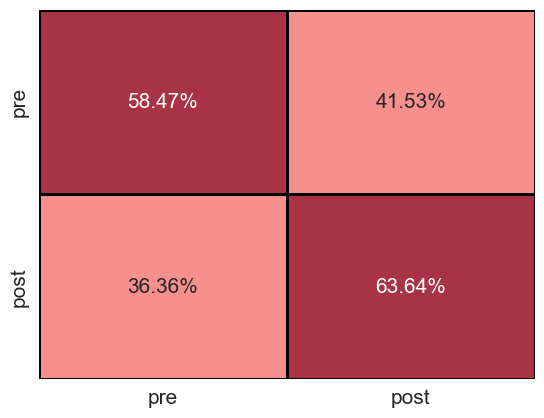

In [18]:
## plot confusion matrix as heatmap
hm = sns.heatmap(data = cm1p, cmap=mypalettePink, center=0.5 ,annot = True, linewidths = 1, 
                 linecolor = "Black",cbar = False, xticklabels = ['pre','post'], yticklabels = ['pre','post'], fmt = '.2%')

plt.savefig(plotdir + 'confusionMatrix1102.png')

In [19]:
## extract class probabilities for further analysis
classprobsFinal = mymodel_balanced.predict_proba(x_holdout)

## create data frame of holdout subjects and their class probabilities
classprobsdfFinal = pd.DataFrame(classprobsFinal, columns = ['prob pre', 'prob post'])

## add subjectkeys of holdout subjects to df
classprobsdfFinal['subjectkey'] = holdout_subs

## add actual menacharche status to df
classprobsdfFinal['Actual'] = y_holdout

## add predicted menarche status to df
classprobsdfFinal['Predicted'] = preds

In [20]:
## create conditions for TP, FN, FP and TN
conditions = [
    (classprobsdfFinal['Actual'] == 1) & (classprobsdfFinal['Predicted'] == 1),
    (classprobsdfFinal['Actual'] == 1) & (classprobsdfFinal['Predicted'] == 0),
    (classprobsdfFinal['Actual'] == 0) & (classprobsdfFinal['Predicted'] == 1),
    (classprobsdfFinal['Actual'] == 0) & (classprobsdfFinal['Predicted'] == 0)
    ]

## save TP, FN, FP and TN as list in the same order as conditions above
values = ['True Positive', 'False Negative', 'False Positive', 'True Negative']

## add column to df that contains info on what type of classification(error) occured
classprobsdfFinal['tpfptnfn'] = np.select(conditions, values)

In [21]:
## post menarche class probabilites
classprobsFinalPost = classprobsFinal[:,1]

In [22]:
## for chance level 
random_probs = [0 for _ in range(len(Y))]
## ROC curves of performance on test data
ns_fpr, ns_tpr, _ = roc_curve(Y, random_probs)
ts_fpr, ts_tpr, _ = roc_curve(y_holdout, classprobsFinalPost)

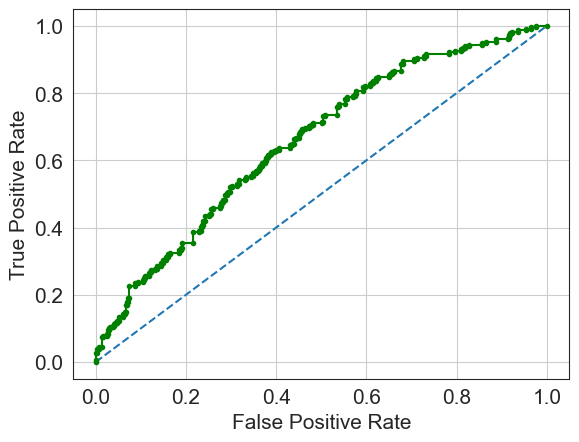

In [23]:
## plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(ts_fpr, ts_tpr, marker = '.', color = 'Green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [24]:
## Permutation test: Lables in the training data get shuffled and a model gets trained on the random training data
## and is then applied to the holdout data. Resulting (random) accuracies are compared to the baseline accuracy 
## generated by training the model on non-shuffled training data and applying it to the holdout data

observed_accuracyTestData = balanced_accuracy_score(y_holdout,preds)

## 1000 permutations and a list to save the results
n_permutations = 1000
permuted_accuraciesTestData = []

## Use the same parameters as in the original model
random_model = LinearDiscriminantAnalysis(n_components=1, shrinkage=0.7, solver='lsqr')

for _ in range(n_permutations):
    ## shuffle the labels in the training data
    shuffled_labels = np.random.permutation(Y)
    ## train the model on random data
    random_model.fit(X,shuffled_labels) 
    ## use the model to classify menarche status in the test data
    predsRandom = random_model.predict(x_holdout)
    ## calculate and append accuracies to the list
    permuted_accuracy = balanced_accuracy_score(y_holdout, predsRandom)
    permuted_accuraciesTestData.append(permuted_accuracy)

# calculate the p-value by looking at number of models with learned randomness that performed as good or better than the
# original model
p_valuePermTest = (np.sum(permuted_accuraciesTestData >= observed_accuracyTestData) + 1) / (n_permutations + 1)
print(f"Observed Accuracy: {observed_accuracyTestData}")
print(mean(permuted_accuraciesTestData))
print(f"P-value: {p_valuePermTest}")

Observed Accuracy: 0.6105445866782382
0.4986288679498704
P-value: 0.000999000999000999


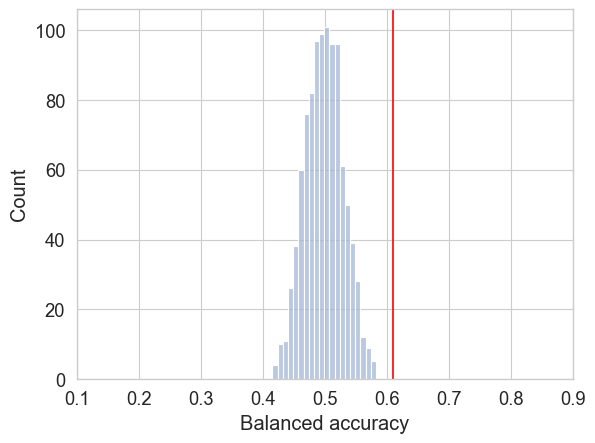

In [25]:
sns.set_style('whitegrid')
sns.set_context("paper", font_scale=1.5)
fig, ax = plt.subplots()

sns.histplot(permuted_accuraciesTestData, bins=20, color='#A4B7D6')

ax.axvline(observed_accuracyTestData, color="red")

ax.set_xlim([0.1,0.9])

ax.set_xlabel("Balanced accuracy")

#ax.set_title('Permutation Test Performed with Holdout Data', fontsize = 15)
plt.savefig(plotdir + 'permutationTest_holdout_new1102.png')

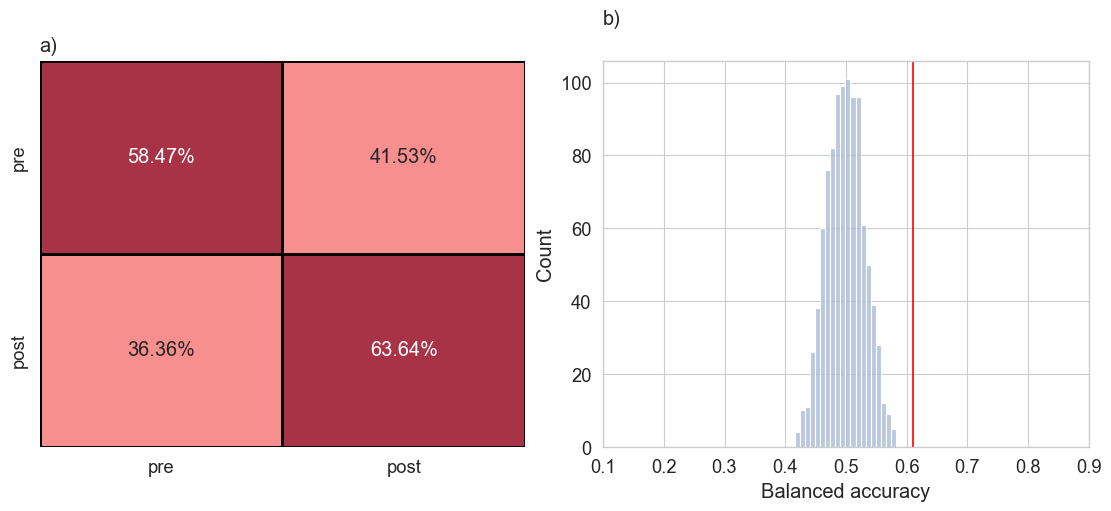

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (11,5), constrained_layout = True)

hm = sns.heatmap(data = cm1p, cmap=mypalettePink, center=0.5 ,annot = True, linewidths = 1, 
                 linecolor = "Black",cbar = False, xticklabels = ['pre','post'], 
                 yticklabels = ['pre','post'], fmt = '.2%', ax = ax1)

ax1.text(0,-0.05,"a)")

p1 = sns.histplot(permuted_accuraciesTestData, bins=20, color='#A4B7D6', ax = ax2)

p1.axvline(observed_accuracyTestData, color="red")

p1.set_xlim([0.1,0.9])

p1.set_xlabel("Balanced accuracy")

ax2.text(0.1,116,"b)")


plt.savefig(plotdir + 'Figure1.png', dpi = 1000)

In [27]:
# save dataframe
classprobsdfFinal.to_csv('classprobabilitesDFfinal_independently_harmonizedScanMatchedAgePredFeaturesShrink071102.csv', index = False)

# 4. Validating that unbalanced test data is valid by repeating with balanced data

In [28]:
## drop 188 random pre-menarche subjects to balance the data
indices_to_drop = Test[Test['pds_f5_y_P'] == 1].sample(n=188, axis='rows', random_state = 1).index
TestBalanced = Test.drop(indices_to_drop)

## remeber subjectkeys of test subjects
holdout_subsBalanced = TestBalanced['subjectkey']

## drop subjectkey
X_TestAgePredBalanced = TestBalanced.drop(columns=['subjectkey','pds_f5_y_P'])

## menarche data (1=pre, 4=post) as labels
y_TestBalanced = TestBalanced['pds_f5_y_P']

## Preprocess the dataset: Standardize by removing mean and scaling to unit variance
sc_h = StandardScaler()
x_holdoutBalanced = sc_h.fit_transform(X_TestAgePredBalanced)

## Encode target labels with value between 0 and n_classes-1
le_h = LabelEncoder()
y_holdoutBalanced = le_h.fit_transform(y_TestBalanced)

## perform binary prediction of menarche status
predsBalanced = mymodel_balanced.predict(x_holdoutBalanced)

In [29]:
## create confusion matrix for model applied to balanced test data
cm2 = confusion_matrix(y_holdoutBalanced, predsBalanced)
print(cm2)
cm2p = cm2.copy()

## turn int to float
cm2p = cm2p * 1.0

## calculate percentages per row
cm2p[0,] = cm2[0,] / (cm2[0,0] + cm2[0,1])
cm2p[1,] = cm2p[1,] / (cm2p[1,0] + cm2p[1,1])

## calculate accuracy score
tn, fp, fn, tp = confusion_matrix(y_holdoutBalanced, predsBalanced).ravel()
ac_preds2 = balanced_accuracy_score(y_holdoutBalanced,predsBalanced)
print(ac_preds2)
print(tn, fp, fn, tp)

[[147  84]
 [ 94 137]]
0.6147186147186148
147 84 94 137


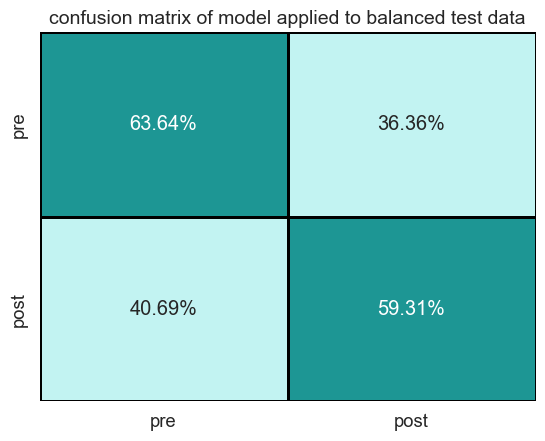

In [30]:
## plot confusion matrix of model applied to balanced test data as heatmap
hm = sns.heatmap(data = cm2p, cmap=mypaletteBlue, center=0.5 ,annot = True, linewidths = 1, 
                 linecolor = "Black",cbar = False, xticklabels = ['pre','post'], yticklabels = ['pre','post'], fmt = '.2%')
plt.title('confusion matrix of model applied to balanced test data', size = 14)
plt.savefig(plotdir + 'cmTuned_independently_harmonizedAgePredFeaturesPINK.png')

In [31]:
## To avoid accidental bias when randomly dropping 188 participants, the process of balancing, training and applying
## the model is repeated 1000 times
n_rounds = 1000
balanced_accuracies = []

for i in range(n_rounds):
    ## balance the sample by dropping 188 random pre-menarche subjects
    indices_to_drop = Test[Test['pds_f5_y_P'] == 1].sample(n=188,axis='rows', random_state = i).index
    TestBalanced = Test.drop(indices_to_drop)

    ## perform the preprocessing, training and prediction
    X_TestPredBalanced = TestBalanced.drop(columns=['subjectkey','pds_f5_y_P'])
    y_TestBalanced = TestBalanced['pds_f5_y_P']

    sc_h = StandardScaler()
    x_holdoutBalanced = sc_h.fit_transform(X_TestPredBalanced)

    le_h = LabelEncoder()
    y_holdoutBalanced = le_h.fit_transform(y_TestBalanced)

    predsBalanced = mymodel_balanced.predict(x_holdoutBalanced)
    accs = balanced_accuracy_score(y_holdoutBalanced,predsBalanced)
    balanced_accuracies.append(accs)
    
print(mean(balanced_accuracies))

0.612374458874459


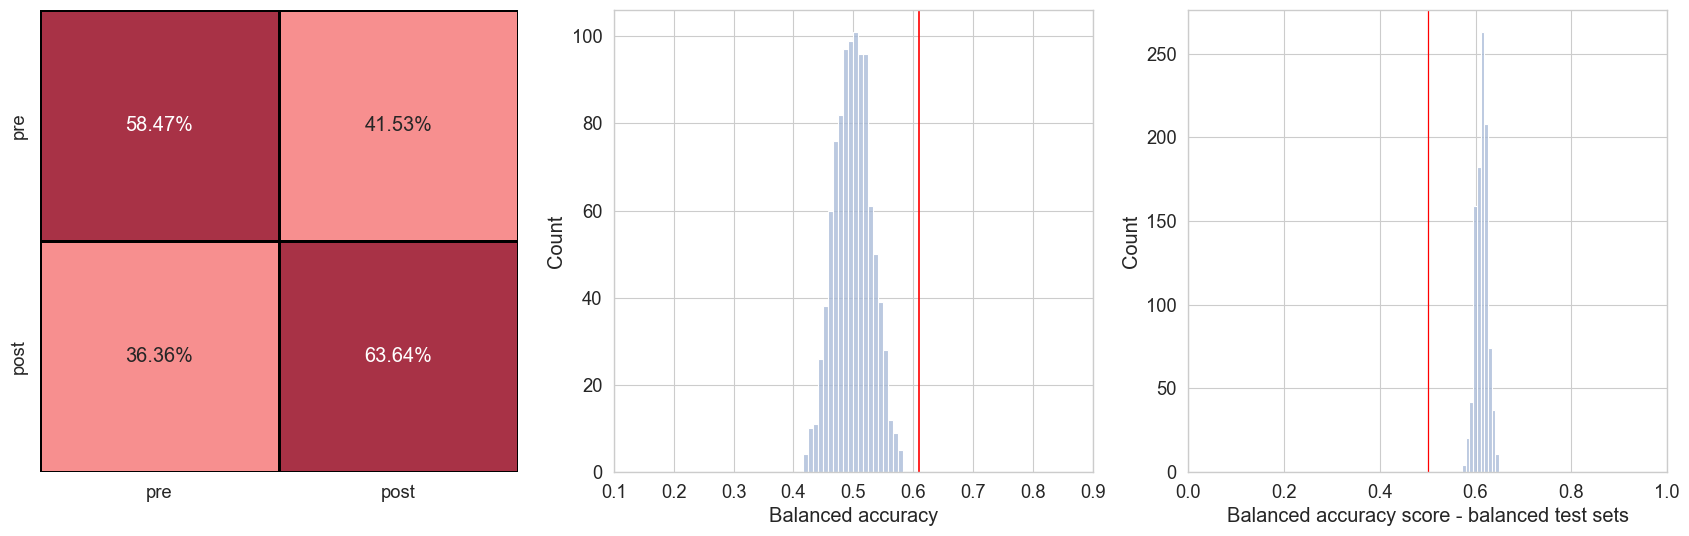

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (21,6))

hm = sns.heatmap(data = cm1p, cmap=mypalettePink, center=0.5 ,annot = True, linewidths = 1, 
                 linecolor = "Black",cbar = False, xticklabels = ['pre','post'], 
                 yticklabels = ['pre','post'], fmt = '.2%', ax = ax1)

p1 = sns.histplot(permuted_accuraciesTestData, bins=20, color='#A4B7D6', ax = ax2)
p1.axvline(observed_accuracyTestData, color="red")
p1.set_xlim([0.1,0.9])
p1.set_xlabel("Balanced accuracy")

p2 = sns.histplot(balanced_accuracies, bins=10, color='#A4B7D6', ax = ax3)
p2.set_xlim(0, 1)
p2.set_xlabel("Balanced accuracy score - balanced test sets")
p2.axvline(0.5, color='red', linewidth = 0.9)

plt.savefig(plotdir + 'plot2ConfMatPerm.png', dpi = 1000)

In [33]:
max(balanced_accuracies)

0.6493506493506493

In [34]:
min(balanced_accuracies)

0.5714285714285714

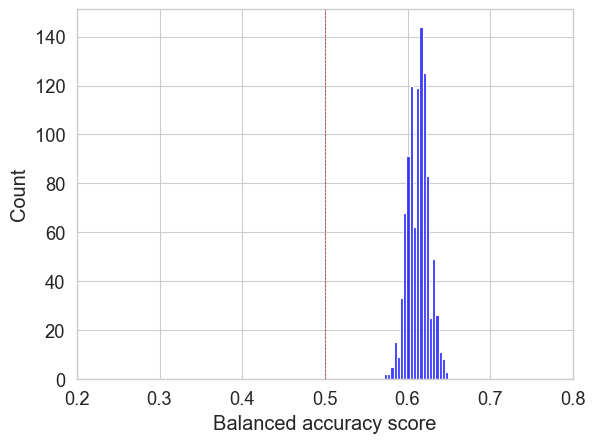

In [35]:
# Plot a histogram of all accuracies on balanced holdout data
sns.histplot(balanced_accuracies, bins=20, color='blue')

plt.xlim(0.2, 0.8)
plt.xlabel("Balanced accuracy score")

plt.axvline(0.5, color='#AC2123', linewidth = 0.5, ls = '--')

plt.savefig(plotdir + '1000balanced_accuracies1902.pdf', dpi = 1000)